In [1]:
import json
from tqdm import tqdm
import os
from random import choice
from itertools import groupby
import tensorflow as tf

/home/llluckygirl/envs/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class KB(object):
    def __init__(self,kb_directory):
        print("start loading kb_data...")
        self.kb_directory = kb_directory
        self.id2kb,self.types,self.predicate = self.get_id2kb()
        self.kb2id = self.get_kb2id()
        self.kb = list(self.kb2id.keys())
        self.id = list(self.id2kb.keys())
        self.print_info()

    def print_info(self):
        print("KB DATA INFORMATION")
        print("TOKEN SIZE:{}".format(self.get_token_size()))
        print("ID SIZE:{}".format(len(self)))
        print("TYPE SIZE:{}".format(len(self.types)))
        print("PREDICATE SIZE:{}".format(len(self.predicate)))
    def get_id2kb(self):
        print("construct id2kb dict...")
        id2kb = {}
        kbtype = set()
        predicate = set()
        multi_type = []
        with open(self.kb_directory) as f:
            for l in tqdm(f):
                tmp = json.loads(l)
                subject_id = tmp['subject_id']
                subject_alias = list(set([tmp['subject']] + tmp.get('alias', [])))
                subject_alias = [alias.lower() for alias in subject_alias]
                subject_type = [i.lower() for i in tmp['type']]
                kbtype.update(subject_type)
                try:
                    assert(len(tmp['type'])==1)
                except AssertionError:
                    multi_type.append(tmp['type'])
                subject_data = {}
                for i in tmp['data']:
                    predicate.add(i['predicate'].lower())
                    subject_data[i['predicate'].lower()] = i['object'].lower()
                if subject_data:
                    id2kb[subject_id] = {'alias': subject_alias, 'data': subject_data,'type':subject_type}
#         print(multi_type)
        return id2kb,kbtype,predicate
    def get_kb2id(self):
        print("construct kb2id dict...")
        kb2id = {}
        for i,j in self.id2kb.items():
            for k in j['alias']:
                if k not in kb2id:
                    kb2id[k] = []
                kb2id[k].append(i)
        return kb2id
    def __len__(self):
        return len(self.id2kb)
    def get_token_size(self):
        return len(self.kb)
    def update_kb(self,update_list):
        print('updating kb data')
        print('current kb data information...')
        self.print_info()
        print('the length of update',len(update_list))
        for dt in tqdm(update_list):
            tmp_token = dt[0]
            tmp_id = dt[1]
            if tmp_token not in self.id2kb[tmp_id]['alias']:
                self.id2kb[tmp_id]['alias'].append(tmp_token)
            if tmp_token not in self.kb2id:
                self.kb2id[tmp_token] = []
            if tmp_id not in self.kb2id[tmp_token]:
                self.kb2id[tmp_token].append(tmp_id)
        self.kb = list(self.kb2id.keys())
        self.id = list(self.id2kb.keys())
        print('update done.')
        self.print_info()
#     def save_kb(self):
        

In [3]:
kb_data = KB('./ccks2019_el/kb_data')

2213it [00:00, 22129.55it/s]

start loading kb_data...
construct id2kb dict...


399252it [00:18, 21102.37it/s]


construct kb2id dict...
KB DATA INFORMATION
TOKEN SIZE:303375
ID SIZE:399233
TYPE SIZE:51
PREDICATE SIZE:41841


In [4]:
with open('./data/all_data.json') as f:
    train_data,dev_data,test_data = json.load(f)

In [5]:
print('traindata size:',len(train_data))
print('devdata size:',len(dev_data))
print('testdata size',len(test_data))

traindata size: 84262
devdata size: 851
testdata size 852


In [6]:
print(train_data[0])

{'text_id': '81967', 'text': '电影《淘金岁月》下载 急求', 'mention_data': [['电影', 0, '148097'], ['淘金岁月', 3, '50357']]}


kb = kb_data.kb
update_set = []
for dt in tqdm(train_data):
    tmp = dt['mention_data']
    for m in tmp:
        if m[0] not in kb:
            update_set.append([m[0],m[2]])
print(len(update_set))

In [7]:
def get_updata_list(kb_data,data):
    update_set = []
    id2kb = kb_data.id2kb
    for dt in tqdm(data):
        tmp = dt['mention_data']
        for m in tmp:
            if m[0] not in id2kb[m[2]]['alias']:
                update_set.append([m[0],m[2]])
    return update_set

In [8]:
update_set = get_updata_list(kb_data,train_data)

100%|██████████| 84262/84262 [00:00<00:00, 258676.54it/s]


In [9]:
print(len(update_set))

9068


In [10]:
print(update_set[0])

['澳羽赛', '98783']


In [11]:
print(kb_data.id2kb['98783'])

{'alias': ['2012年澳大利亚羽毛球公开赛'], 'data': {'摘要': '2012年澳大利亚羽毛球公开赛，于4月3日至8日在悉尼开赛，奖金： usd120,000，知名球员陶菲克、李炫一、文萨、阮天明、佐佐木翔、西蒙均将出席。本次公开赛在悉尼市的会展中心举行，涵盖男单、女单、男双、女双和混双等全部5项赛事，是伦敦奥运会之前重要的一项积分赛。', '举办地点': '悉尼', '举办时间': '4月3日至8日', '中文名': '2012年澳大利亚羽毛球公开赛', '奖金': 'usd120,000', '义项描述': '2012年澳大利亚羽毛球公开赛', '标签': '体育赛事'}, 'type': ['event']}


In [12]:
print(len(update_set)/len(train_data))

0.10761671928033989


In [13]:
from topsim import TopSim

In [14]:
ts = TopSim(kb_data.kb)

In [15]:
for i in range(10):
    print(update_set[i])
    search = ts.search(update_set[i][0])
    print(kb_data.kb[search[0][1][0]])
    print(kb_data.id2kb[update_set[i][1]])

['澳羽赛', '98783']
澳网公开赛
{'alias': ['2012年澳大利亚羽毛球公开赛'], 'data': {'摘要': '2012年澳大利亚羽毛球公开赛，于4月3日至8日在悉尼开赛，奖金： usd120,000，知名球员陶菲克、李炫一、文萨、阮天明、佐佐木翔、西蒙均将出席。本次公开赛在悉尼市的会展中心举行，涵盖男单、女单、男双、女双和混双等全部5项赛事，是伦敦奥运会之前重要的一项积分赛。', '举办地点': '悉尼', '举办时间': '4月3日至8日', '中文名': '2012年澳大利亚羽毛球公开赛', '奖金': 'usd120,000', '义项描述': '2012年澳大利亚羽毛球公开赛', '标签': '体育赛事'}, 'type': ['event']}
['男主', '19423']
男主角
{'alias': ['男主角'], 'data': {'摘要': '男主角是戏剧、电影等影视作品和acgn作品中故事的主要男性角色，相对于男主角，还有男配角(次要角色)、路人甲和反派等。', '特点': '主要男性角色', '外文名': 'hero', '中文名': '男主角', '其他名称': '男猪脚', '义项描述': '主要男性角色', '标签': '人物'}, 'type': ['vocabulary']}
['一切法无我讲义', '323599']
讲义
{'alias': ['教授'], 'data': {'摘要': '教授，是一种高等教育体系中的职称。多指在大学或社区学院中执教的资深教师与研究员，但教授与研究员是有区别的。教授有教课的任务，而研究员则没有。教授为大学教师职称的最高级别。中文的教授两字则源于‘传教授业’的字义，是中国古代就已使用的学官名称，在中国汉代、唐代的大学中都设此职位。与英文没有关联。日语中则与中文同用“教授”来称呼大学中的老师。', '外文名': 'professor', '英文缩写': 'prof', '级别': '大学教师职称的最高级别', '中文名': '教授', '义项描述': '教师职称', '标签': '历史'}, 'type': ['thing']}
['和县', '272896']
太和县
{'alias': ['永和县', '永和'], 'data': {'摘要': '永和县，隶属于山西省

In [16]:
import jieba
class ngram_search(object):
    def __init__(self,data,kb,ngram = 4,similarity = 0.4):
        self.n = ngram
        self.similarity = similarity
        self.data = data
        self.kb = kb
        self.cut_data,self.offset = self.cut_words()
        self.ts = TopSim(self.kb)
        self.candidates = self.get_candidates(self.similarity)
        self.cand_name,self.cand_off = self.get_candidates_name()
    def cut_words(self):
        print('starting build ngram list')
        print('ngram',self.n)
        result = []
        offset = []
        for d in tqdm(self.data):
#             print(d)
#             print(' '.join(jieba.cut(d)))
            tmp = list(jieba.cut(d))
            n = len(tmp)
            tmp_off = [0]
#             tmp_off = [len(''.join(tmp[:i])) for i in range(len(tmp))]
            for i in range(len(tmp)-1):
                tmp_off.append(tmp_off[-1]+len(tmp[i]))
            for j in range(2,self.n+1):
                for i in range(j-1,n):
                    tmp.append(''.join(tmp[i-j+1:i+1]))
                    tmp_off.append(tmp_off[i-j+1])
#                     tmp_off.append(''.join(tmp[:i-n+1]))
            result.append(tmp)
            offset.append(tmp_off)
        return result,offset
    def get_candidates(self,similarity = 0.5):
        self.similarity = similarity
        print('starting build candidates list')
        print('similarity:',self.similarity)dev_x = [i
        candidates = []
        for dt in tqdm(self.cut_data):
            ts_result = []
            for i in dt:
                tmp = ts.search(i)
                if tmp and tmp[0][0] > self.similarity:
                    ts_result.append(tmp)
                else:
                    ts_result.append([])
            candidates.append(ts_result)
        return candidates
    def get_candidates_name(self):
        print('starting get candidates name and offset')
        cand_name = []
        cand_offset = []
        for i in tqdm(range(len(self.candidates))):
            cand = []
            off = []
            for j in range(len(self.candidates[i])):
                if self.candidates[i][j]:
#                     print(self.candidates[i][j])
#                     print(self.candidates[i][j][0][1][0])
#                     print(self.kb[self.candidates[i][j][0][1][0]])
                    cand.append(self.kb[self.candidates[i][j][0][1][0]])
                    off.append(self.offset[i][j])
            cand_name.append(cand)
            cand_offset.append(off)
        return cand_name,cand_offset

In [17]:
dev_x = [i['text'] for i in dev_data]
print(type(dev_x[0]))
en = []
for i in dev_data:
    tmp = []
    for j in i['mention_data']:
        tmp.append(j[0])
    en.append(tmp)

<class 'str'>


In [18]:
# kb_data_test = KB('./ccks2019_el/kb_data')

In [19]:
# kb_data_test.update_kb(update_set)

In [20]:
ns = ngram_search(dev_x,kb_data.kb)
# ns_test = ngram_search(dev_x,kb_data_test.kb)

  0%|          | 0/851 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


starting build ngram list
ngram 4


Loading model cost 0.924 seconds.
Prefix dict has been built succesfully.
  0%|          | 2/851 [00:00<00:52, 16.08it/s]

starting build candidates list
similarity: 0.4


100%|██████████| 851/851 [00:00<00:00, 37422.84it/s]

starting get candidates name and offset


In [21]:
def evaluate_cand(cand_name,ground_truth):
    recall = []
    precision = []
    for i in tqdm(range(len(ground_truth))):
        tp = 0
        for j in ground_truth[i]:
            if j in cand_name[i]:
                tp += 1
        recall.append(tp/len(ground_truth[i]))
        precision.append(tp/len(cand_name[i]))
    print('average recall: {}'.format(sum(recall)/len(recall)))
    print('average precision: {}'.format(sum(precision)/len(precision)))
    return recall, precision
        

In [22]:
r1,p1 = evaluate_cand(ns.cand_name,en)
# r2,p2 = evaluate_cand(ns_test.cand_name,en)

100%|██████████| 851/851 [00:00<00:00, 146989.77it/s]

average recall: 0.9422406878928613
average precision: 0.20862911788597688


In [23]:
recl = []
prec = []
for n in range(2,11):
    ns_test = ngram_search(dev_x,kb_data.kb,n,0)
    tmp1,tmp2 = evaluate_cand(ns_test.cand_name,en)
    recl.append(tmp1)
    prec.append(tmp2)

100%|██████████| 851/851 [00:00<00:00, 4614.02it/s]

starting build ngram list
ngram 2



  0%|          | 3/851 [00:00<00:30, 27.49it/s]

starting build candidates list
similarity: 0


 49%|████▊     | 414/851 [00:00<00:00, 4137.84it/s]

starting get candidates name and offset
average recall: 0.9194938727547417
average precision: 0.12431142408275862
starting build ngram list
ngram 3


  0%|          | 2/851 [00:00<00:47, 17.95it/s]

starting build candidates list
similarity: 0


100%|██████████| 851/851 [00:00<00:00, 29143.52it/s]


starting get candidates name and offset


 46%|████▋     | 395/851 [00:00<00:00, 3941.58it/s]

average recall: 0.9505665603491686
average precision: 0.08961520731101098
starting build ngram list
ngram 4


  0%|          | 2/851 [00:00<00:49, 17.00it/s]

starting build candidates list
similarity: 0


100%|██████████| 851/851 [00:00<00:00, 21558.49it/s]


starting get candidates name and offset


 49%|████▊     | 414/851 [00:00<00:00, 4136.81it/s]

average recall: 0.9521725141290355
average precision: 0.07123612252902027
starting build ngram list
ngram 5


  0%|          | 2/851 [00:00<01:07, 12.60it/s]

starting build candidates list
similarity: 0


100%|██████████| 851/851 [00:00<00:00, 17705.21it/s]


starting get candidates name and offset


 46%|████▌     | 390/851 [00:00<00:00, 3897.93it/s]

average recall: 0.9535434502825804
average precision: 0.0607702607924077
starting build ngram list
ngram 6


  0%|          | 2/851 [00:00<01:06, 12.82it/s]

starting build candidates list
similarity: 0


100%|██████████| 851/851 [00:00<00:00, 13975.54it/s]


starting get candidates name and offset


 46%|████▌     | 388/851 [00:00<00:00, 3879.49it/s]

average recall: 0.9535434502825804
average precision: 0.054248179054653345
starting build ngram list
ngram 7


  0%|          | 1/851 [00:00<01:25,  9.89it/s]

starting build candidates list
similarity: 0


100%|██████████| 851/851 [00:00<00:00, 13147.32it/s]


starting get candidates name and offset


 88%|████████▊ | 752/851 [00:00<00:00, 3801.48it/s]

average recall: 0.9535434502825804
average precision: 0.04997977254602169
starting build ngram list
ngram 8


  0%|          | 1/851 [00:00<01:46,  7.97it/s]

starting build candidates list
similarity: 0


100%|██████████| 851/851 [00:00<00:00, 12653.42it/s]


starting get candidates name and offset


 43%|████▎     | 370/851 [00:00<00:00, 3697.27it/s]

average recall: 0.9535434502825804
average precision: 0.047124003558001205
starting build ngram list
ngram 9


  0%|          | 1/851 [00:00<01:53,  7.49it/s]

starting build candidates list
similarity: 0


  0%|          | 0/851 [00:00<?, ?it/s]

starting get candidates name and offset


 84%|████████▍ | 719/851 [00:00<00:00, 3534.70it/s]

average recall: 0.9535434502825804
average precision: 0.045181317848886
starting build ngram list
ngram 10


  0%|          | 1/851 [00:00<01:47,  7.90it/s]

starting build candidates list
similarity: 0


100%|██████████| 851/851 [00:00<00:00, 13250.69it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 123948.77it/s]

average recall: 0.9535434502825804
average precision: 0.04386174908771406


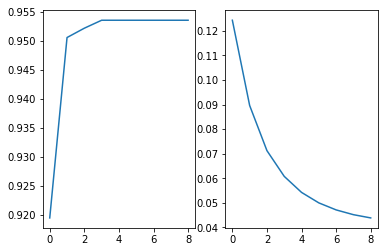

In [27]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
r = [sum(rec)/len(rec) for rec in recl]
p = [sum(pre)/len(pre) for pre in prec]
x = np.arange(len(r))
plt.subplot(211)
plt.plot(x,r)
plt.subplot(212)
plt.plot(x,p)
plt.show()

In [ ]:
plt.plot(r,p)
plt.show()

In [28]:
recl1  = []
prec1  = []
for i in range(10):
    ns_test = ngram_search(dev_x,kb_data.kb,3,i/10)
    tmp1,tmp2 = evaluate_cand(ns_test.cand_name,en)
    recl1.append(tmp1)
    prec1.append(tmp2)

 46%|████▌     | 390/851 [00:00<00:00, 3883.07it/s]

starting build ngram list
ngram 3


  0%|          | 3/851 [00:00<00:35, 23.90it/s]

starting build candidates list
similarity: 0.0


100%|██████████| 851/851 [00:00<00:00, 25776.15it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4623.29it/s]


average recall: 0.9505665603491686
average precision: 0.08961520731101098
starting build ngram list
ngram 3


  0%|          | 3/851 [00:00<00:32, 25.78it/s]

starting build candidates list
similarity: 0.1


100%|██████████| 851/851 [00:00<00:00, 26976.99it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4435.98it/s]


average recall: 0.9505665603491686
average precision: 0.09073588438171638
starting build ngram list
ngram 3


  0%|          | 2/851 [00:00<00:43, 19.53it/s]

starting build candidates list
similarity: 0.2


100%|██████████| 851/851 [00:00<00:00, 23194.48it/s]


starting get candidates name and offset


 42%|████▏     | 358/851 [00:00<00:00, 3576.26it/s]

average recall: 0.9498419226680092
average precision: 0.10297022935474574
starting build ngram list
ngram 3


  0%|          | 3/851 [00:00<00:33, 25.04it/s]

starting build candidates list
similarity: 0.3


100%|██████████| 851/851 [00:00<00:00, 31398.52it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4791.06it/s]


average recall: 0.9475738160520764
average precision: 0.1341932590275719
starting build ngram list
ngram 3


  0%|          | 3/851 [00:00<00:35, 23.95it/s]

starting build candidates list
similarity: 0.4


  0%|          | 0/851 [00:00<?, ?it/s]

starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4580.14it/s]


average recall: 0.9394596459813845
average precision: 0.2276406214739996
starting build ngram list
ngram 3


  0%|          | 3/851 [00:00<00:32, 26.37it/s]

starting build candidates list
similarity: 0.5


  0%|          | 0/851 [00:00<?, ?it/s]

starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4648.40it/s]


average recall: 0.9253390035998725
average precision: 0.3014931725912347
starting build ngram list
ngram 3


  0%|          | 2/851 [00:00<00:42, 19.80it/s]

starting build candidates list
similarity: 0.6


100%|██████████| 851/851 [00:00<00:00, 56331.81it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4612.04it/s]


average recall: 0.9045791132747649
average precision: 0.3334597778012105
starting build ngram list
ngram 3


  0%|          | 3/851 [00:00<00:34, 24.87it/s]

starting build candidates list
similarity: 0.7


100%|██████████| 851/851 [00:00<00:00, 58292.28it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4927.11it/s]


average recall: 0.8948454665845965
average precision: 0.3451870147202631
starting build ngram list
ngram 3


  0%|          | 3/851 [00:00<00:33, 25.65it/s]

starting build candidates list
similarity: 0.8


100%|██████████| 851/851 [00:00<00:00, 47509.65it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4443.90it/s]


average recall: 0.8940620744968567
average precision: 0.347444562629985
starting build ngram list
ngram 3


  0%|          | 3/851 [00:00<00:32, 26.27it/s]

starting build candidates list
similarity: 0.9


100%|██████████| 851/851 [00:00<00:00, 41239.88it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 179310.39it/s]

average recall: 0.8940620744968567
average precision: 0.347444562629985


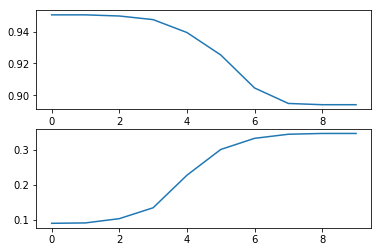

In [33]:
import matplotlib.pyplot as plt
plt.figure()
r = [sum(rec)/len(rec) for rec in recl1]
p = [sum(pre)/len(pre) for pre in prec1]
x = np.arange(len(r))
plt.subplot(211)
plt.plot(x,r)
plt.subplot(212)
plt.plot(x,p)
# plt.subplot(133)


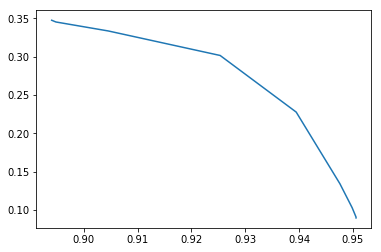

In [32]:
plt.plot(r,p)
plt.show()

In [35]:
recl1  = []
prec1  = []
for i in range(10):
    ns_test = ngram_search(dev_x,kb_data.kb,4,i/10)
    tmp1,tmp2 = evaluate_cand(ns_test.cand_name,en)
    recl1.append(tmp1)
    prec1.append(tmp2)

100%|██████████| 851/851 [00:00<00:00, 4337.04it/s]

starting build ngram list
ngram 4



  0%|          | 2/851 [00:00<00:51, 16.34it/s]

starting build candidates list
similarity: 0.0


100%|██████████| 851/851 [00:00<00:00, 23057.54it/s]


starting get candidates name and offset


 52%|█████▏    | 446/851 [00:00<00:00, 4448.07it/s]

average recall: 0.9521725141290355
average precision: 0.07123612252902027
starting build ngram list
ngram 4


  0%|          | 2/851 [00:00<00:48, 17.51it/s]

starting build candidates list
similarity: 0.1


  0%|          | 0/851 [00:00<?, ?it/s]

starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4365.84it/s]


average recall: 0.9521725141290355
average precision: 0.0719810803122966
starting build ngram list
ngram 4


  0%|          | 2/851 [00:00<00:48, 17.54it/s]

starting build candidates list
similarity: 0.2


100%|██████████| 851/851 [00:00<00:00, 25683.60it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4607.69it/s]


average recall: 0.951447876447876
average precision: 0.08299827107020495
starting build ngram list
ngram 4


  0%|          | 2/851 [00:00<00:49, 17.17it/s]

starting build candidates list
similarity: 0.3


100%|██████████| 851/851 [00:00<00:00, 31099.51it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4542.69it/s]


average recall: 0.9491797698319432
average precision: 0.11842653751563575
starting build ngram list
ngram 4


  0%|          | 2/851 [00:00<00:48, 17.38it/s]

starting build candidates list
similarity: 0.4


  0%|          | 0/851 [00:00<?, ?it/s]

starting get candidates name and offset


 99%|█████████▊| 840/851 [00:00<00:00, 4046.14it/s]

average recall: 0.9422406878928613
average precision: 0.20862911788597688
starting build ngram list
ngram 4


  0%|          | 2/851 [00:00<00:50, 16.88it/s]

starting build candidates list
similarity: 0.5


  0%|          | 0/851 [00:00<?, ?it/s]

starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4598.08it/s]


average recall: 0.936639434465521
average precision: 0.290554662322251
starting build ngram list
ngram 4


  0%|          | 2/851 [00:00<00:50, 16.84it/s]

starting build candidates list
similarity: 0.6


100%|██████████| 851/851 [00:00<00:00, 43246.01it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4646.52it/s]


average recall: 0.9295497360714746
average precision: 0.3298326484085003
starting build ngram list
ngram 4


  0%|          | 2/851 [00:00<00:51, 16.58it/s]

starting build candidates list
similarity: 0.7


100%|██████████| 851/851 [00:00<00:00, 54971.47it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4522.44it/s]


average recall: 0.9236351258090382
average precision: 0.3503564044804457
starting build ngram list
ngram 4


  0%|          | 2/851 [00:00<00:48, 17.59it/s]

starting build candidates list
similarity: 0.8


100%|██████████| 851/851 [00:00<00:00, 51141.99it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 4450.60it/s]


average recall: 0.9222641896554934
average precision: 0.35325588129296603
starting build ngram list
ngram 4


  0%|          | 2/851 [00:00<00:50, 16.97it/s]

starting build candidates list
similarity: 0.9


100%|██████████| 851/851 [00:00<00:00, 52858.16it/s]


starting get candidates name and offset


100%|██████████| 851/851 [00:00<00:00, 340879.83it/s]

average recall: 0.9222641896554934
average precision: 0.35325588129296603


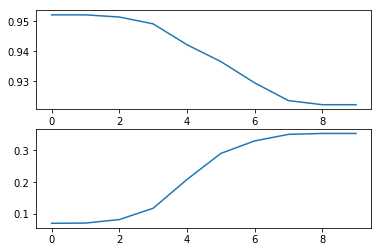

In [36]:
import matplotlib.pyplot as plt
plt.figure()
r = [sum(rec)/len(rec) for rec in recl1]
p = [sum(pre)/len(pre) for pre in prec1]
x = np.arange(len(r))
plt.subplot(211)
plt.plot(x,r)
plt.subplot(212)
plt.plot(x,p)

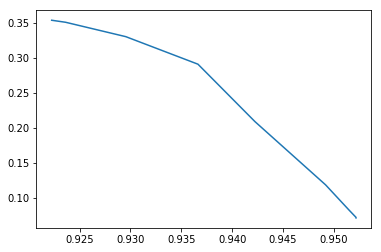

In [37]:
plt.plot(r,p)
plt.show()